In [1]:
pip install torch torchvision torchaudio tensorflow matplotlib pandas wandb tqdm opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

2025-01-09 13:33:16.368023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 13:33:16.380199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736425996.393060   15098 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736425996.396893   15098 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 13:33:16.412490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Loading the Data


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append('/work/AML_Project/5_Models')
import os
#from DataLoaders.dataloader import SingleFrameDataset3D, DeepPhysDataPreprocessor

from DataLoaders.dataloader_augmentation import (
    SingleFrameDataset3D,
    PhysioAugmentation,
    AugmentedDataset,
    DeepPhysDataPreprocessorWithAugment
)


train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Train_crop"
val_dir   = "/work/AML_Project/5_Models/PhysNEt/DataSet/Validation_crop"
test_dir  = "/work/AML_Project/5_Models/PhysNEt/DataSet/Test_crop"

#train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Train_color"
#val_dir   = "/work/AML_Project/5_Models/PhysNEt/DataSet/Validation_co
# 
# #lor"
#test_dir  = "/work/AML_Project/5_Models/PhysNEt/DataSet/Test_color"

"""
preprocessor = DeepPhysDataPreprocessor()
train_loader, val_loader, test_loader = preprocessor.create_dataloaders(
    train_dir, 
    val_dir, 
    test_dir,
    batch_size=32
)
"""

# Define batch size
batch_size = 32

# Create an instance of the preprocessor with augmentations
preprocessor = DeepPhysDataPreprocessorWithAugment()

# Create DataLoaders for training, validation, and testing
train_loader, val_loader, test_loader = preprocessor.create_dataloaders_with_augment(
    train_dir=train_dir,
    val_dir=val_dir,
    test_dir=test_dir,
    batch_size=batch_size
)    


Train files: 22391, Val files: 8393, Test files: 9851
Initializing SingleFrameDataset3D with 22391 files.
Initializing SingleFrameDataset3D with 8393 files.
Initializing SingleFrameDataset3D with 9851 files.


# Negative Pearson Correlation Loss Function

In [4]:
import torch
import torch.nn as nn

class NegativePearsonCorrelation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        """
        Computes the Negative Pearson Correlation between predictions and targets,
        treating the entire batch as one set of (prediction,target) pairs. 
        Both y_pred and y_true are expected to be 1D or 2D with a single value per sample.
        """
        # Flatten to 1D if necessary.
        # For a single scalar per sample, shape might be [batch_size] or [batch_size, 1].
        # Flattening ensures we have shape = [batch_size].
        y_pred = y_pred.view(-1).float()
        y_true = y_true.view(-1).float()

        # Means (scalars)
        pred_mean = torch.mean(y_pred)
        true_mean = torch.mean(y_true)

        # Deviations from mean
        pred_dev = y_pred - pred_mean
        true_dev = y_true - true_mean

        # Covariance and variances
        covariance = torch.sum(pred_dev * true_dev)
        pred_var   = torch.sum(pred_dev ** 2)
        true_var   = torch.sum(true_dev ** 2)

        # Pearson correlation (scalar)
        pearson_corr = covariance / (torch.sqrt(pred_var) * torch.sqrt(true_var) + 1e-8)

        # Return negative correlation as the "loss"
        return -pearson_corr


# Setting up Training and Validation 

In [5]:
import os
import random
import shutil
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
#import cv2
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-5, model_path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model_path = model_path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.model_path)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                epochs=20, device='cuda', early_stopping=None):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Create the loss curves plot for W&B
    wandb.define_metric("epoch")
    wandb.define_metric("train_loss", step_metric="epoch")
    wandb.define_metric("val_loss", step_metric="epoch")
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_ground_truth = []
        print(f"Epoch {epoch + 1}/{epochs}")
        train_progress = tqdm(train_loader, desc="Training")
        for sequences, eda_targets, bvp_inputs in train_progress:
            sequences, eda_targets, bvp_inputs = sequences.to(device), eda_targets.to(device), bvp_inputs.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences, bvp_inputs)
            loss = criterion(outputs, eda_targets)
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_progress.set_postfix(loss=loss.item())
            
            # Collect training predictions and ground truth
            train_predictions.extend(outputs.detach().cpu().numpy())
            train_ground_truth.extend(eda_targets.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_ground_truth = []
        
        with torch.no_grad():
            for sequences, eda_targets, bvp_inputs in tqdm(val_loader, desc="Validation"):
                sequences, eda_targets, bvp_inputs = sequences.to(device), eda_targets.to(device), bvp_inputs.to(device)
                outputs = model(sequences, bvp_inputs)
                loss = criterion(outputs, eda_targets)

                val_loss += loss.item()
                
                val_predictions.extend(outputs.cpu().numpy())
                val_ground_truth.extend(eda_targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Create and log loss curves plot
        fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
        ax_loss.plot(range(1, epoch + 2), train_losses, label='Training Loss', marker='o')
        ax_loss.plot(range(1, epoch + 2), val_losses, label='Validation Loss', marker='o')
        ax_loss.set_title('Training and Validation Loss Curves')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
        ax_loss.grid(True)

        # Create prediction vs actual plots for both training and validation
        fig_pred, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Training predictions plot
        ax1.plot(train_predictions[:100], label='Predictions', alpha=0.7)
        ax1.plot(train_ground_truth[:100], label='Ground Truth', alpha=0.7)
        ax1.set_title('Training: Predictions vs Ground Truth')
        ax1.legend()
        ax1.grid(True)
        
        # Validation predictions plot
        ax2.plot(val_predictions[:100], label='Predictions', alpha=0.7)
        ax2.plot(val_ground_truth[:100], label='Ground Truth', alpha=0.7)
        ax2.set_title('Validation: Predictions vs Ground Truth')
        ax2.legend()
        ax2.grid(True)

        # Create a table of predictions vs. actuals over the validation set
        data = [[i, float(t), float(p)] for i, (t, p) in enumerate(zip(val_ground_truth, val_predictions))]
        table = wandb.Table(data=data, columns=["index", "actual", "prediction"])

        # Log a line plot to W&B
        line_plot = wandb.plot.line(table, "index", ["actual", "prediction"], title="Actual vs Prediction Over Index")
        wandb.log({"prediction_vs_actual_line": line_plot})


        # Log everything to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "loss_curves": wandb.Image(fig_loss),
            "predictions_vs_ground_truth": wandb.Image(fig_pred)
        })

        # Close the figures to free memory
        plt.close(fig_loss)
        plt.close(fig_pred)

        # Print epoch results
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if early_stopping is not None:
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break

    # Log final run summary table
    wandb.run.summary.update({
        "best_val_loss": min(val_losses),
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "total_epochs": len(train_losses),
        "early_stopped": early_stopping.early_stop if early_stopping else False,
    })

    return train_losses, val_losses


def setup_training(model, learning_rate=0.001, weight_decay=0.001):
    #criterion = nn.MSELoss()
    criterion = NegativePearsonCorrelation()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )
    early_stopping = EarlyStopping(patience=15, min_delta=1e-4)
    
    return criterion, optimizer, scheduler, early_stopping


def plot_loss_curves(train_losses, val_losses):
    """
    Plots the training and validation loss curves on the same graph.

    Args:
        train_losses (list or array-like): List of training loss values per epoch.
        val_losses (list or array-like): List of validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)  

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Curves', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(epochs)  
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()





# Initialize Model and W&B

In [6]:
from PhysNet_SpaTemp_Model import PhysNet_SpaTempBVP
# initiliaze model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PhysNet_SpaTempBVP(dropout_rate=0.5) 
model = model.to(device)

# log in in weight and biases 
config = wandb.config
wandb.init(project="FinalPhysNet_Run",entity="aml-final-project", config=config, settings=wandb.Settings(init_timeout=300))



wandb: Currently logged in as: natalie-schlachter (aml-final-project). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/home/ucloud/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25


Training:   0%|          | 0/700 [00:00<?, ?it/s]/work/AML_Project/5_Models/DataLoaders/DataLoader_Augment_loaders.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data 

Epoch 1/25
Training Loss: -0.0089
Validation Loss: 0.0117
Learning Rate: 0.001000
Epoch 2/25


Validation: 100%|██████████| 263/263 [00:05<00:00, 45.10it/s]


Epoch 2/25
Training Loss: -0.0163
Validation Loss: 0.0101
Learning Rate: 0.001000
Epoch 3/25


Validation: 100%|██████████| 263/263 [00:05<00:00, 45.05it/s]


Epoch 3/25
Training Loss: -0.0171
Validation Loss: 0.0079
Learning Rate: 0.001000
Epoch 4/25


Validation: 100%|██████████| 263/263 [00:07<00:00, 35.71it/s]


Epoch 4/25
Training Loss: -0.0186
Validation Loss: 0.0090
Learning Rate: 0.001000
Epoch 5/25


Validation: 100%|██████████| 263/263 [00:06<00:00, 43.74it/s]


Epoch 5/25
Training Loss: -0.0198
Validation Loss: 0.0147
Learning Rate: 0.001000
Epoch 6/25


Validation: 100%|██████████| 263/263 [00:06<00:00, 39.86it/s]


Epoch 6/25
Training Loss: -0.0189
Validation Loss: 0.0147
Learning Rate: 0.001000
Epoch 7/25


Validation: 100%|██████████| 263/263 [00:04<00:00, 63.20it/s]


Epoch 7/25
Training Loss: -0.0175
Validation Loss: 0.0128
Learning Rate: 0.001000
Epoch 8/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 67.85it/s]


Epoch 8/25
Training Loss: -0.0178
Validation Loss: 0.0109
Learning Rate: 0.001000
Epoch 9/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 73.60it/s]


Epoch 9/25
Training Loss: -0.0189
Validation Loss: 0.0110
Learning Rate: 0.000100
Epoch 10/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 73.52it/s]


Epoch 10/25
Training Loss: -0.0168
Validation Loss: 0.0123
Learning Rate: 0.000100
Epoch 11/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 73.82it/s]


Epoch 11/25
Training Loss: -0.0180
Validation Loss: 0.0132
Learning Rate: 0.000100
Epoch 12/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 73.31it/s]


Epoch 12/25
Training Loss: -0.0192
Validation Loss: 0.0133
Learning Rate: 0.000100
Epoch 13/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 72.21it/s]


Epoch 13/25
Training Loss: -0.0200
Validation Loss: 0.0134
Learning Rate: 0.000100
Epoch 14/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 72.92it/s]


Epoch 14/25
Training Loss: -0.0207
Validation Loss: 0.0136
Learning Rate: 0.000100
Epoch 15/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 72.89it/s]


Epoch 15/25
Training Loss: -0.0206
Validation Loss: 0.0139
Learning Rate: 0.000010
Epoch 16/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 72.41it/s]


Epoch 16/25
Training Loss: -0.0212
Validation Loss: 0.0140
Learning Rate: 0.000010
Epoch 17/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 66.35it/s]


Epoch 17/25
Training Loss: -0.0212
Validation Loss: 0.0141
Learning Rate: 0.000010
Epoch 18/25


Validation: 100%|██████████| 263/263 [00:03<00:00, 71.16it/s]


Epoch 18/25
Training Loss: -0.0212
Validation Loss: 0.0142
Learning Rate: 0.000010
Early stopping triggered


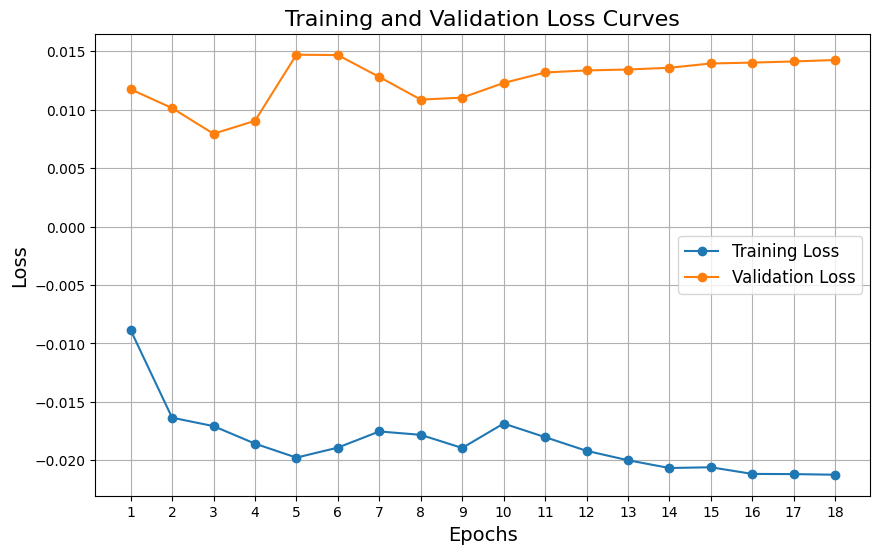

In [7]:
# Hyperparameters
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.001
num_epochs = 25

criterion, optimizer, scheduler, early_stopping = setup_training(model)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=num_epochs,
    device='cuda',  # Or 'cpu' if you don't have a GPU
    early_stopping=early_stopping
)

plot_loss_curves(train_losses, val_losses)

# Apply Grad-Cam to Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


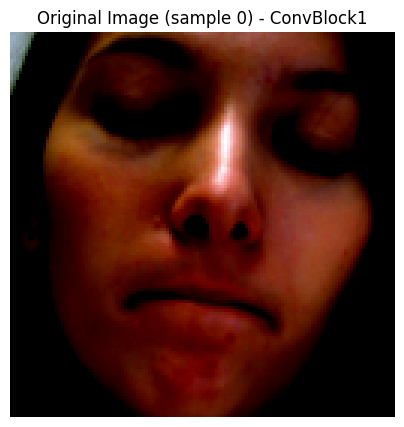

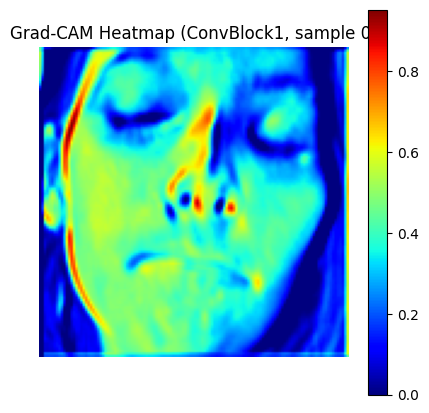

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


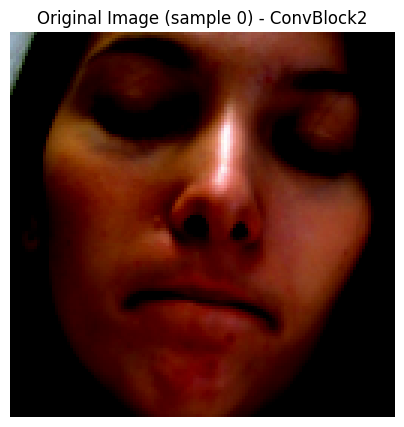

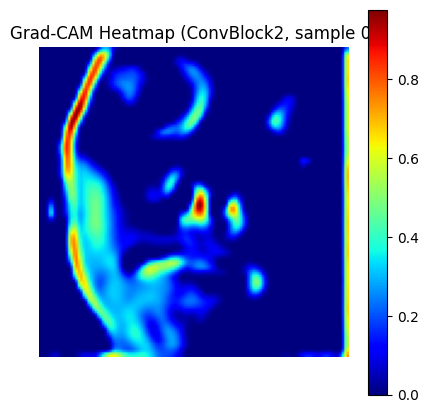

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


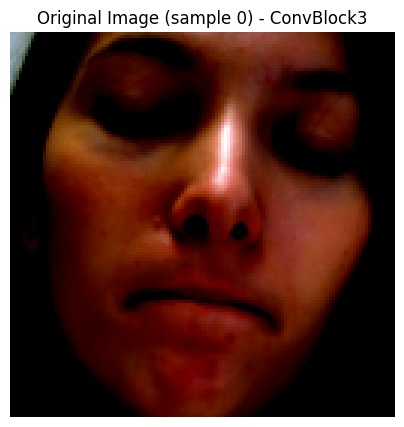

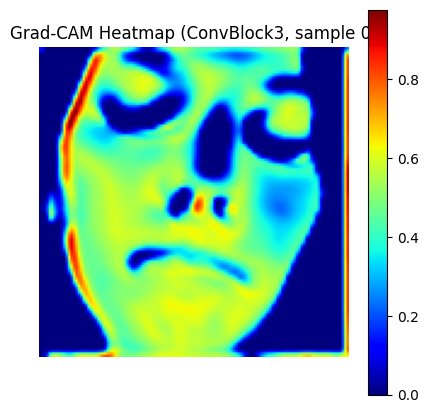

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


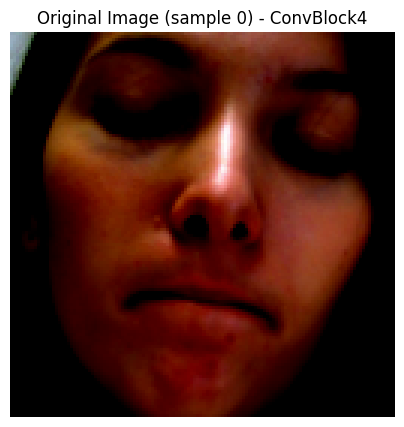

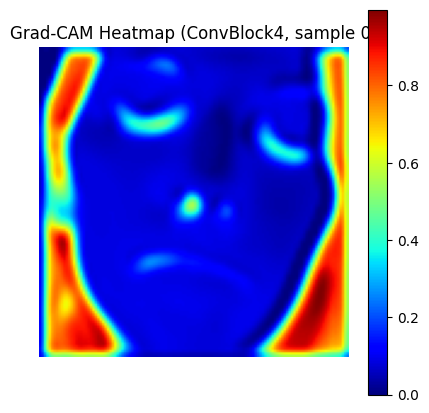

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


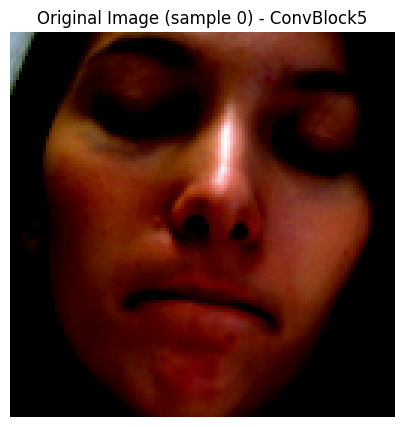

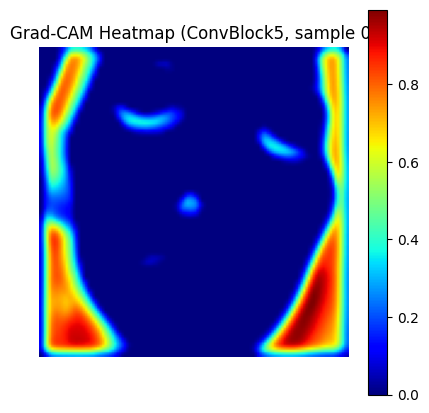

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


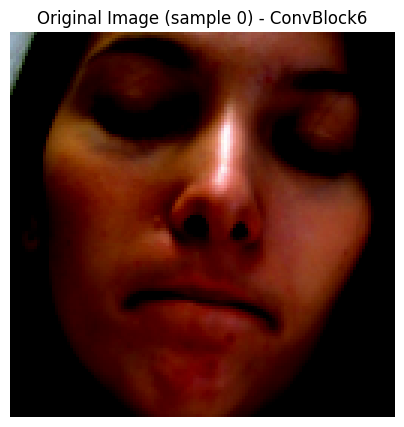

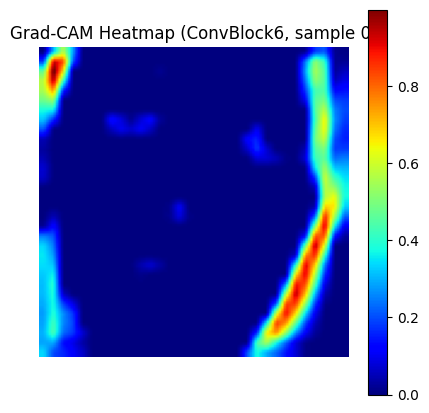

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


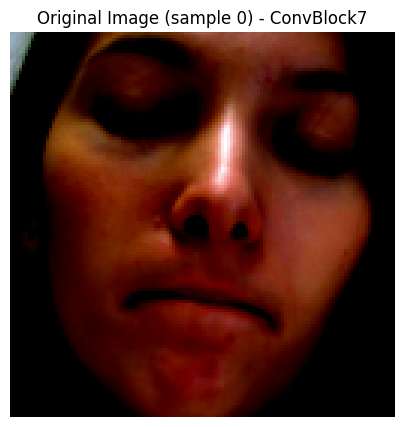

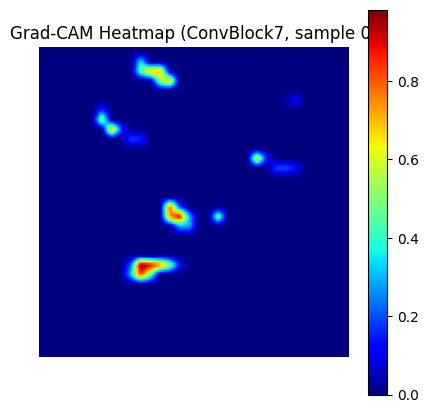

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


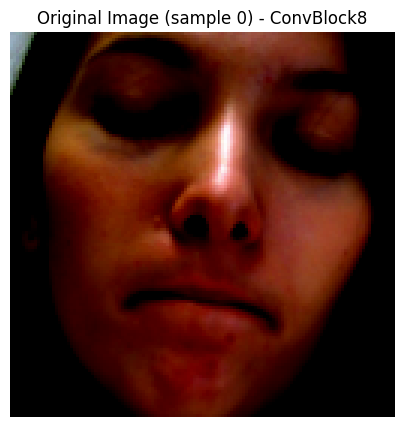

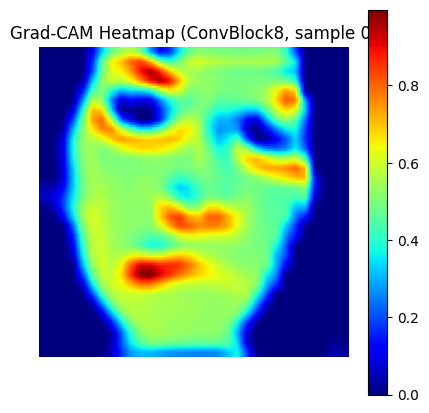

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


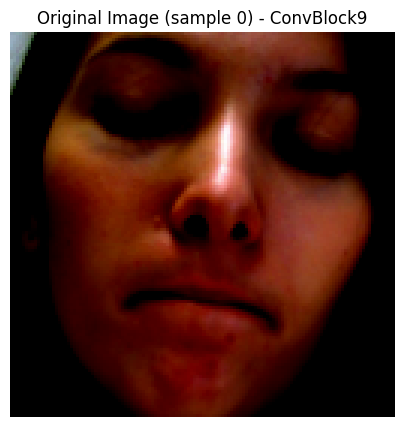

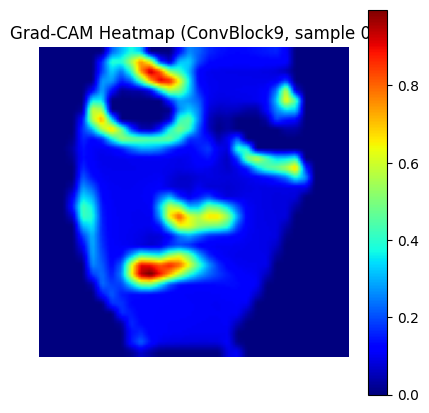

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


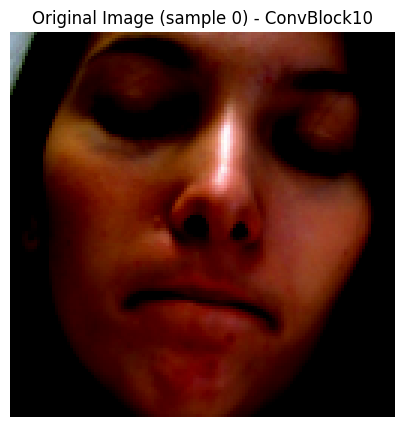

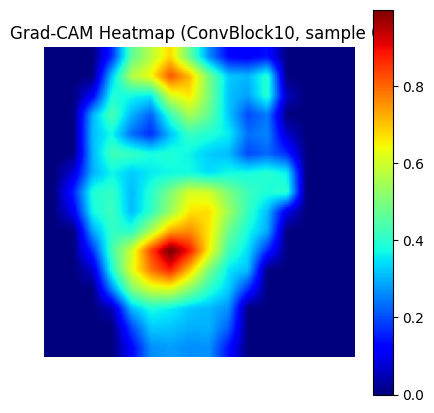

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


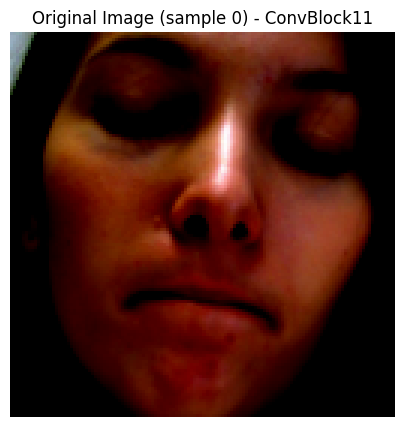

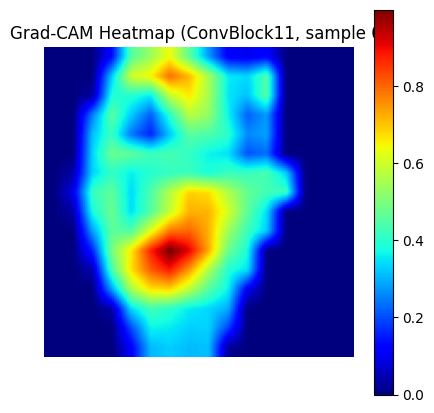

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


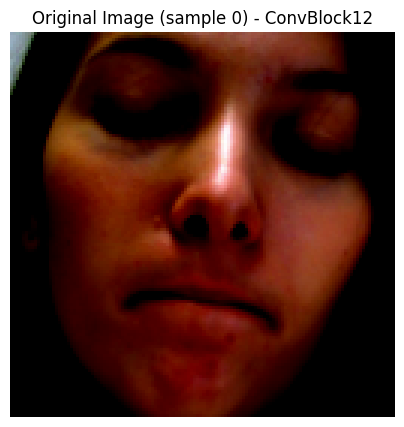

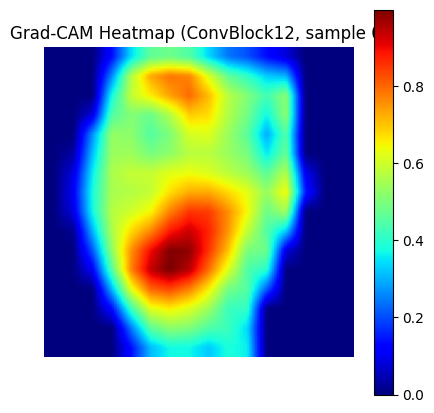

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


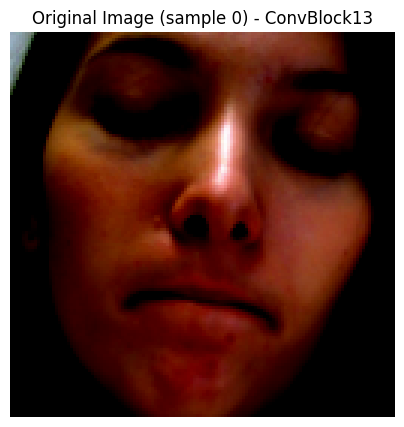

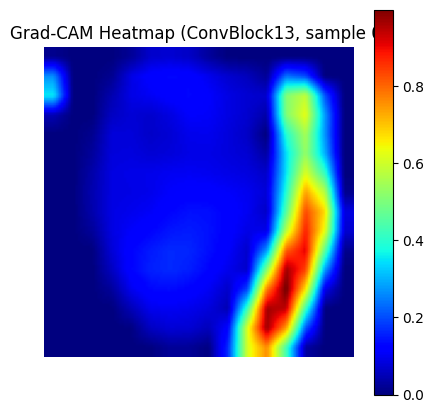

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


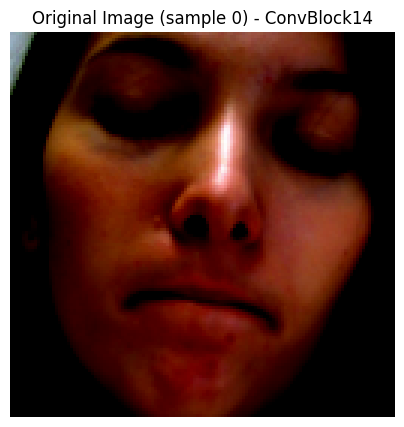

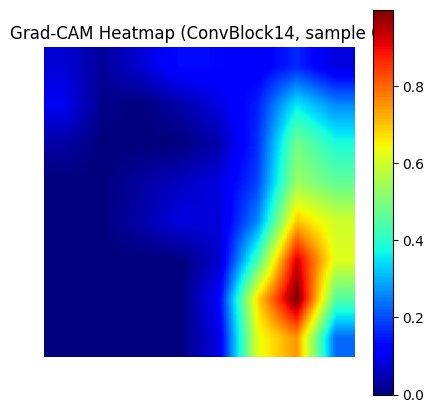

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


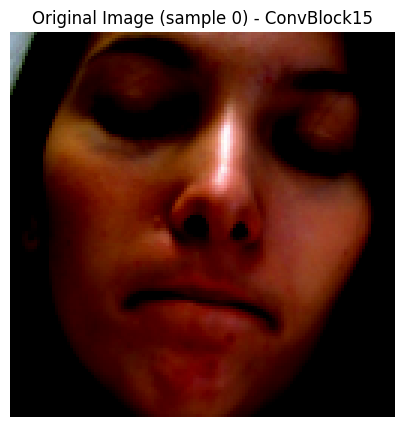

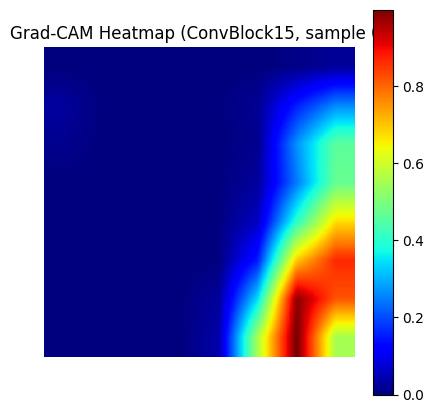

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM3D:
    """
    Grad-CAM for 3D convolutional models.
    This version assumes the final output is a single scalar 
    (e.g. your NegativePearsonCorrelation to a single EDA value).
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        
        self.activations = None
        self.gradients   = None

        # Register hooks
        self._forward_hook = target_layer.register_forward_hook(self._forward_hook_fn)
        self._backward_hook = target_layer.register_backward_hook(self._backward_hook_fn)

    def _forward_hook_fn(self, module, input, output):
        self.activations = output  

    def _backward_hook_fn(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]  

    def remove_hooks(self):
        """Call this when done to avoid duplicate hooks."""
        self._forward_hook.remove()
        self._backward_hook.remove()

    def forward(self, sequences, bvp_inputs):
        """Simply run the forward pass on the model."""
        return self.model(sequences, bvp_inputs)

    def backward(self, output):
        """
        Run backward pass given a scalar output. 
        If output is (B,), pass a vector of ones so each sample
        in the batch gets a gradient.
        """
        self.model.zero_grad()

        if output.ndim > 0:
            grad_output = torch.ones_like(output)
            output.backward(grad_output, retain_graph=True)
        else:
            output.backward(retain_graph=True)

    def generate_cam(self, sequences, bvp_inputs):
        """High-level API: forward -> backward -> compute Grad-CAM"""
        # 1) Forward
        output = self.forward(sequences, bvp_inputs)

        # 2) Backward
        self.backward(output)

        # 3) Create CAM
        return self._compute_cam()

    def _compute_cam(self):
        """
        Grad-CAM calculation:
          - alpha_k = GlobalAveragePool(gradients) for each channel k
          - weighted sum: sum_{k}(alpha_k * activations_k)
          - ReLU
          - Then upsample to input size if desired
        """
        if self.activations is None or self.gradients is None:
            raise ValueError("Activations or gradients not found. "
                             "Did you run forward and backward pass?")

        # activations => (B, C, D, H, W)
        # gradients   => (B, C, D, H, W)

        # 1) Compute channel-wise mean of gradients => alpha_k
        alpha = self.gradients.mean(dim=[2, 3, 4], keepdim=True)  # shape (B, C, 1, 1, 1)

        # 2) Weighted sum of activations => (B, 1, D, H, W)
        weighted_activations = alpha * self.activations

        # 3) Sum across channels => (B, 1, D, H, W)
        cam = weighted_activations.sum(dim=1, keepdim=True)

        # 4) ReLU
        cam = F.relu(cam)

        # 5) Upsample to input resolution => (B, 1, 1, 128, 128)
        cam_upsampled = F.interpolate(
            cam, size=(1, 128, 128), mode='trilinear', align_corners=False
        )

        # 6) Remove dims => (B, 128, 128)
        cam_2d = cam_upsampled.squeeze(2).squeeze(1)

        # 7) Normalize each sample to [0,1] range
        B, H, W = cam_2d.shape
        cam_2d_flat = cam_2d.view(B, -1)  # (B, H*W)
        min_vals = cam_2d_flat.min(dim=1, keepdim=True)[0]
        max_vals = cam_2d_flat.max(dim=1, keepdim=True)[0]
        cam_2d_flat_norm = (cam_2d_flat - min_vals) / (max_vals - min_vals + 1e-8)
        cam_2d = cam_2d_flat_norm.view(B, H, W)

        return cam_2d



# Grad-CAM Execution / Visualization

# 1) Switch model to eval
model.eval()

# 2) Define layers list
conv_layers = [
    model.ConvBlock1[0], model.ConvBlock2[0], model.ConvBlock3[0],
    model.ConvBlock4[0], model.ConvBlock5[0], model.ConvBlock6[0],
    model.ConvBlock7[0], model.ConvBlock8[0], model.ConvBlock9[0],
    model.ConvBlock10[0], model.ConvBlock11[0], model.ConvBlock12[0],
    model.ConvBlock13[0], model.ConvBlock14[0], model.ConvBlock15[0]
]

# 3) Get one batch from val_loader
data_iter = iter(val_loader)
sequences, eda_targets, bvp_inputs = next(data_iter)

# 4) Move tensors to GPU if needed
sequences = sequences.to(device)
eda_targets = eda_targets.to(device)
bvp_inputs = bvp_inputs.to(device)

# we set focus on sample 0 here
sample_idx = 0

# Extract the original image (sample 0)
# Suppose shapes: sequences => (B, 3, 1, H, W)
# Remove the time dimension (T=1) and transpose to (H, W, 3).
orig_img_tensor = sequences[sample_idx]        # => (3, 1, H, W)
orig_img_tensor = orig_img_tensor.squeeze(1)   # => (3, H, W)
orig_img_np = orig_img_tensor.detach().cpu().numpy()  # => (3, H, W)

orig_img_np = np.transpose(orig_img_np, (1, 2, 0))  # => (H, W, 3)

# Iterate over each conv layer
cams_for_all_layers = {}

for i, layer in enumerate(conv_layers, start=1):
    # Instantiate Grad-CAM
    gradcam = GradCAM3D(model, layer)
    
    # Generate the CAM => shape (B, 128, 128)
    cam_2d = gradcam.generate_cam(sequences, bvp_inputs)
    cams_for_all_layers[f"ConvBlock{i}"] = cam_2d.detach().cpu()

    # Remove hooks to avoid conflicts in the next iteration
    gradcam.remove_hooks()

    # Visualize only for the sample 0
    if cam_2d.shape[0] > sample_idx:
        
        # 1) Show original image 
        plt.figure(figsize=(5, 5))
        plt.imshow(orig_img_np, cmap='gray')  
        plt.title(f"Original Image (sample {sample_idx}) - ConvBlock{i}")
        plt.axis('off')
        plt.show()

        
        # 2) Show Grad-CAM heatmap
        cam_numpy = cam_2d[sample_idx].detach().cpu().numpy()  # => (128, 128)
        plt.figure(figsize=(5, 5))
        plt.imshow(cam_numpy, cmap='jet')
        plt.title(f"Grad-CAM Heatmap (ConvBlock{i}, sample {sample_idx})")
        plt.colorbar()
        plt.axis('off')
        plt.show()


# Testing

In [8]:
import wandb
from PhysNet_SpaTempNoSeq import PhysNet_SpaTempBVP

def evaluate_on_test(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for sequences, eda_targets, bvp_inputs in test_loader:
            sequences = sequences.to(device)
            eda_targets = eda_targets.to(device)
            bvp_inputs = bvp_inputs.to(device)

            # Forward pass
            outputs = model(sequences, bvp_inputs)
            loss = criterion(outputs, eda_targets)
            test_loss += loss.item()

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(eda_targets.cpu().numpy())

    test_loss_avg = test_loss / len(test_loader)
    print(f"Test Loss: {test_loss_avg:.4f}")

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Log test loss to W&B
    wandb.log({"test loss": test_loss_avg})

    # Log a table of test predictions vs actuals to W&B
    data = [[i, float(t), float(p)] for i, (t, p) in enumerate(zip(all_targets, all_preds))]
    table = wandb.Table(data=data, columns=["index", "actual", "prediction"])

    wandb.log({"test_predictions_table": table})

    return test_loss_avg, all_preds, all_targets


In [9]:
test_loss, test_preds, test_targets = evaluate_on_test(model, test_loader, criterion, device)

wandb.finish()

Test Loss: 0.0174


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
learning_rate,████████▂▂▂▂▂▂▁▁▁▁
test loss,▁
train_loss,█▄▃▃▂▂▃▃▂▃▃▂▂▁▁▁▁▁
val_loss,▅▃▁▂██▆▄▄▅▆▇▇▇▇▇▇█
best_val_loss,0.00793
early_stopped,True
epoch,18
final_train_loss,-0.02123
final_val_loss,0.01424
learning_rate,1e-05
